<center>
<font size = 15>
K-Nearest-Neighbor
</font>
</center>
<br>
<center>
<font size = 8>
핀테크 기계학습
</font>
</center>

<br>


<img src = "./img/knn_간단설명.jpg">

<br><br><br>

<div  style="text-align: right">
    <font size = 7 > 19/03/29 이성령 </font>
</div>

## Library Load

In [35]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import collections
from matplotlib.colors import LogNorm
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import sys
import numpy as np
from scipy.spatial.distance import cdist
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
np.set_printoptions(threshold=np.inf)


<center>
<font size= 10  > 
    Gaussian Mixture Model(GMM) </font>
</center>
<br>

<img src = './img/Gaussian_Mixture.PNG'>

<br>

* 확률이 1이 되게 하는 몇개의 봉우리에서 샘플링 할 숫자를 미리 정한다.
* 그 뒤에 각각의 봉우리에서 해당하는 숫자만큼 샘플링을 하게 되면 GMM 만들 수 있다.

<font size= 5  > Red </font>
    
* `mean` = [(0,4) , (0,2), (3,4) , (0.5,1.5) , (1, 2.5)] , `cov` = [np.diag([1.0,1.0])] * 5 , `p` =[ 0.3,0.3,0.2 ,0.1,0.1]

<font size= 5  > Blue </font>

* `mean` = [(-1.,-1) , (3.5 ,-0.5), (3,3) , (3.5,1.5) , (3.0, 1.5)]  , `cov` = [np.diag([1.0,1.0])] * 5  , `p` =[ 0.2,0.3,0.2 ,0.2,0.1]


In [36]:
def mixture_5(mean = None , cov = None , p = None , N = 200 ) :
    X = np.random.choice( list(np.arange(0,len(p))) , size= N , p = p )
    count = np.bincount(X)
    a = np.random.multivariate_normal(mean[0], cov[0], count[0])
    b = np.random.multivariate_normal(mean[1], cov[1], count[1])
    c = np.random.multivariate_normal(mean[2], cov[2], count[2])
    d = np.random.multivariate_normal(mean[3], cov[3], count[3])
    e = np.random.multivariate_normal(mean[4], cov[4], count[4])
    return np.concatenate((a,b,c,d,e) , axis = 0)

In [37]:
mean = [(0,4) , (0,2), (3,4) , (0.5,1.5) , (1, 2.5)]
cov = [np.diag([1.0,1.0])] * 5
p =[ 0.3,0.3,0.2 ,0.1,0.1]
mix_1 = mixture_5(mean = mean , cov = cov , p =  p)
p =[ 0.2,0.3,0.2 ,0.2,0.1]
mean = [(-1.,-1) , (3.5 ,-0.5), (3,3) , (3.5,1.5) , (3.0, 1.5)]
cov = [np.diag([1.0,1.0])] * 5
mix_2 = mixture_5(mean = mean , cov = cov , p =  p)
label = ["red"] * 200  + ["blue"]  * 200
total  = np.concatenate((mix_1 , mix_2), axis = 0)

## Figure 1

* GMM 2D 분포 생성과 2D Grid 생성

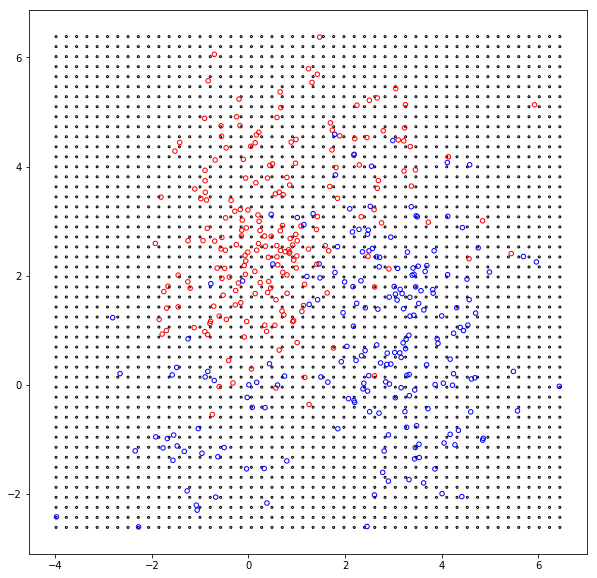

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
x_min, x_max = total[:,0].min() - .01, total[:,0].max() + .01
y_min, y_max = total[:,1].min() - .01, total[:,1].max() + .01
x = np.linspace(x_min , x_max , num = 50)
y = np.linspace(y_min, y_max  , num = 50)
x, y = np.meshgrid(x , y )
plt.scatter(x,y, s=4, facecolors='none', edgecolors= "black"  )
plt.scatter(total[:,0] , total[:,1] ,
            s=20, facecolors='none', edgecolors=label )
plt.show()

## Figure 1.1 Interative Plot

* 1D histogram 과 2D Scatter Plot

In [39]:
XX = np.array([x.ravel(), y.ravel()]).T

total_graph = go.Scatter(
    x = total[:,0],
    y = total[:,1],
    xaxis = 'x',
    yaxis = 'y',
    mode = 'markers',
    marker = dict(color = label , size = 5) )
hist_1 = go.Histogram(
    y = total[:,1],
    xaxis = 'x2',
    marker = dict(color = "red"))

hist_2 = go.Histogram(
    x = total[:,0],
    yaxis = 'y2',
    marker = dict(color = "blue"))

grid_scatter = go.Scatter(
    x = XX[:,0],
    y = XX[:,1],
    xaxis = 'x',
    yaxis = 'y',
    mode = 'markers',
    marker = dict(color = "black" , size = 1))



data = [total_graph , hist_1 , hist_2 , grid_scatter , trace1]


layout = go.Layout(
    autosize = False,
    xaxis = dict( zeroline = False,
                  domain = [0,0.85],
                  showgrid = False ),
    yaxis = dict( zeroline = False,
                  domain = [0,0.85],
                  showgrid = False),
    xaxis2 = dict(zeroline = False,
                  domain = [0.85,1],
                  showgrid = False),
    yaxis2 = dict(zeroline = False,
                  domain = [0.85,1],
                  showgrid = False),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='2D GMM 1D Histogram')

/usr/local/lib/python3.5/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Figure 2

### Bayes Decision Boundary 만들기

* Gaussian Mixture (EM으로 만든 Decision Boundary)
* score_samples 값은 가중화된 logProb

In [40]:
grid_n = 2000
x_min, x_max = total[:,0].min() - .01, total[:,0].max() + .01
y_min, y_max = total[:,1].min() - .01, total[:,1].max() + .01
x = np.linspace(x_min , x_max , num = grid_n)
y = np.linspace(y_min, y_max  , num = grid_n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
gmm = GaussianMixture(n_components=5, covariance_type='diag')
gmm.fit(total[0:201, :])
Z = gmm.score_samples(XX)
Z2 = Z.reshape((grid_n,grid_n))
gmm = GaussianMixture(n_components=5, covariance_type='diag')
gmm.fit(total[200:401, :])
Z = gmm.score_samples(XX) # 
Z1 = Z.reshape((grid_n,grid_n))

In [41]:
D = Z2 - Z1
D = np.abs(D)
D = np.where(D > 0.009 , 1, 0)

#D[D > 0.00004 ] =  1.0
#D[D > 0 ] = 1.0
#D[D < 0.1 ] = 0
#D[D> 0.0001] = -1e-1000
#D[D < -0.0007] = -1e-10000
#D[D > 0.000001 ] = -1e-10000
# plt.contour(X , Y ,  D ,
#             linewidths  = 3 , linestyles  = "dashed" , 
#             norm=LogNorm(vmin=0.0001, vmax=0.001))  ## 이것이 애매함.

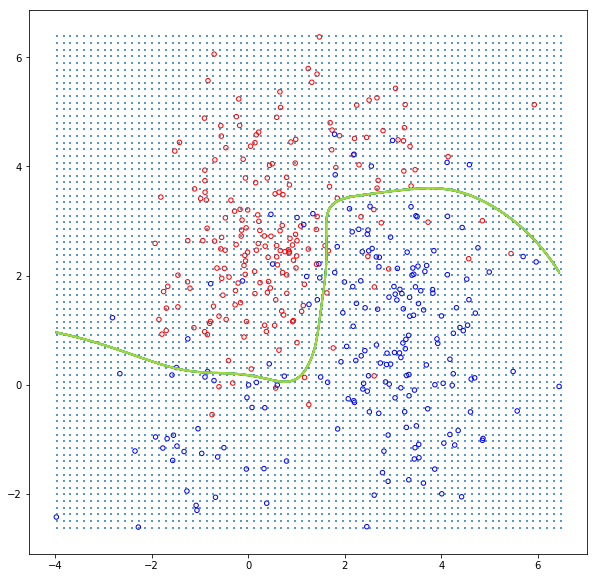

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.contour(X , Y ,  D )
plt.scatter(total[:,0] , total[:,1] ,
            s=20, facecolors='none', edgecolors=label )
x = np.linspace(x_min , x_max , num = 75)
y = np.linspace(y_min, y_max  , num = 75)
x, y = np.meshgrid(x , y )
plt.scatter(x,y, s=4, marker = 1)
plt.show()

## 거리 Matrix 생성

* 샘플과 Grid 사이의 거리 생성하기
* `cdist` 사용

In [43]:
x = np.linspace(x_min , x_max , num = 75)
y = np.linspace(y_min, y_max  , num = 75)
x, y = np.meshgrid(x , y )


In [44]:
grid_xy = np.concatenate((x[:, : , np.newaxis],
                     y[:, : , np.newaxis]),
                    axis = 2)

In [45]:
reshape_grid = grid_xy.reshape(75*75 , 2)
print(total.shape , reshape_grid.shape)

(400, 2) (5625, 2)


In [46]:
metric = "euclidean"
dist = cdist( reshape_grid, total, metric=metric )

## 확인 
* 실제로 `eculidean` 기준으로 해서 잘 된 건지.

In [47]:
a = np.sqrt(np.sum(np.square(reshape_grid[0,:] - total[0,:])))
b = dist[0,0]
print(a==b)

True


# 예측하기

## 1: Blue , 0 : Red

* index > 200 , `Blue`
* index <= 200 , `Red`

##  color

* prob > 0.5 `Blue`
* prob < 0.5 `Red`
* prob == 0.5 `Black` (Decision Boundary)


In [22]:
k = 50
#arg_min_k = np.argpartition(dist, np.argmin(dist, axis=1))[:, :k]
arg_min_k = pd.DataFrame(dist).apply(lambda x : np.argpartition(x , k)[ : k], axis=1).values
change_type = np.where(arg_min_k >= 200  ,  1 , 0 )
prob = np.sum(change_type , axis = 1 ) / k
choice = np.where(prob > 0.5 , "blue" ,
         np.where(prob < 0.5 , "red", "black"))
collections.Counter(choice)

Counter({'black': 73, 'blue': 3116, 'red': 2436})

## Figure 3

### K 에 따른 Decision Boundary Line 생성

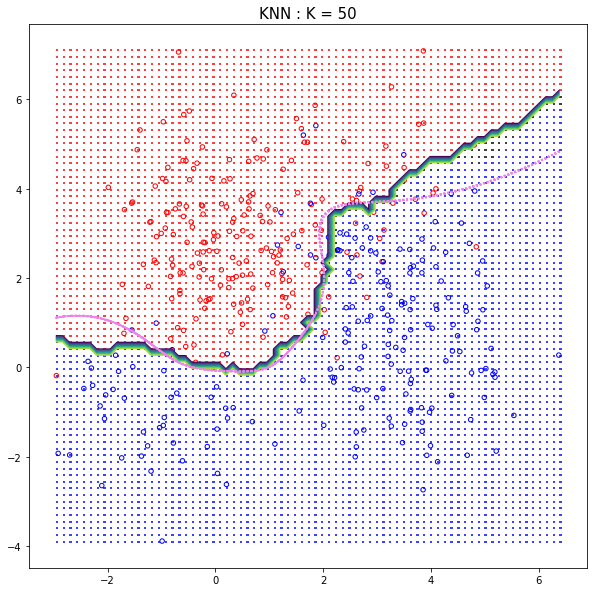

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
pp = np.where(np.array(prob).reshape(75 , 75) >= 0.5 , 1 , 0)
plt.contour(x , y , pp )
plt.contour(X , Y ,  D , colors='violet' , linestyles  ="dotted")
plt.scatter(total[:,0] , total[:,1] ,
            s=20, facecolors='none', edgecolors= label )
x = np.linspace(x_min , x_max , num = 75)
y = np.linspace(y_min, y_max  , num = 75)
x, y = np.meshgrid(x , y )
plt.scatter(x,y, s=5, marker = 1 , c = choice)
plt.title("KNN : K = {}".format(k) , fontsize = 15)
plt.show()

<br>
<center><font size = 10>  Visualization KNN</font></center>
<br>
<br>

<div style = "text-align : center"><font size = 5 > K = 1 , 10 ,100</font></div>


In [81]:
def visual(k ,x ,y , sub) :
    arg_min_k = pd.DataFrame(dist).apply(lambda x : np.argpartition(x , k)[ : k], axis=1).values
    change_type = np.where(arg_min_k >= 200  ,  1 , 0 )
    prob = np.sum(change_type , axis = 1 ) / k
    choice = np.where(prob > 0.5 , "blue" ,
             np.where(prob < 0.5 , "red", "black"))
    pp = np.where(np.array(prob).reshape(75 , 75) >= 0.5 , 1 , 0)
    ax[sub].contour(x , y , pp )
    ax[sub].contour(X , Y ,  D , colors='violet' , linestyles  ="dotted")
    ax[sub].scatter(total[:,0] , total[:,1] ,
                s=20, facecolors='none', edgecolors= label )
    x = np.linspace(x_min , x_max , num = 75)
    y = np.linspace(y_min, y_max  , num = 75)
    x, y = np.meshgrid(x , y )
    ax[sub].scatter(x,y, s=5, marker = 1 , c = choice)
    ax[sub].set_title("KNN : K = {}".format(k) , fontsize = 40)
    ax[sub].axis('off')

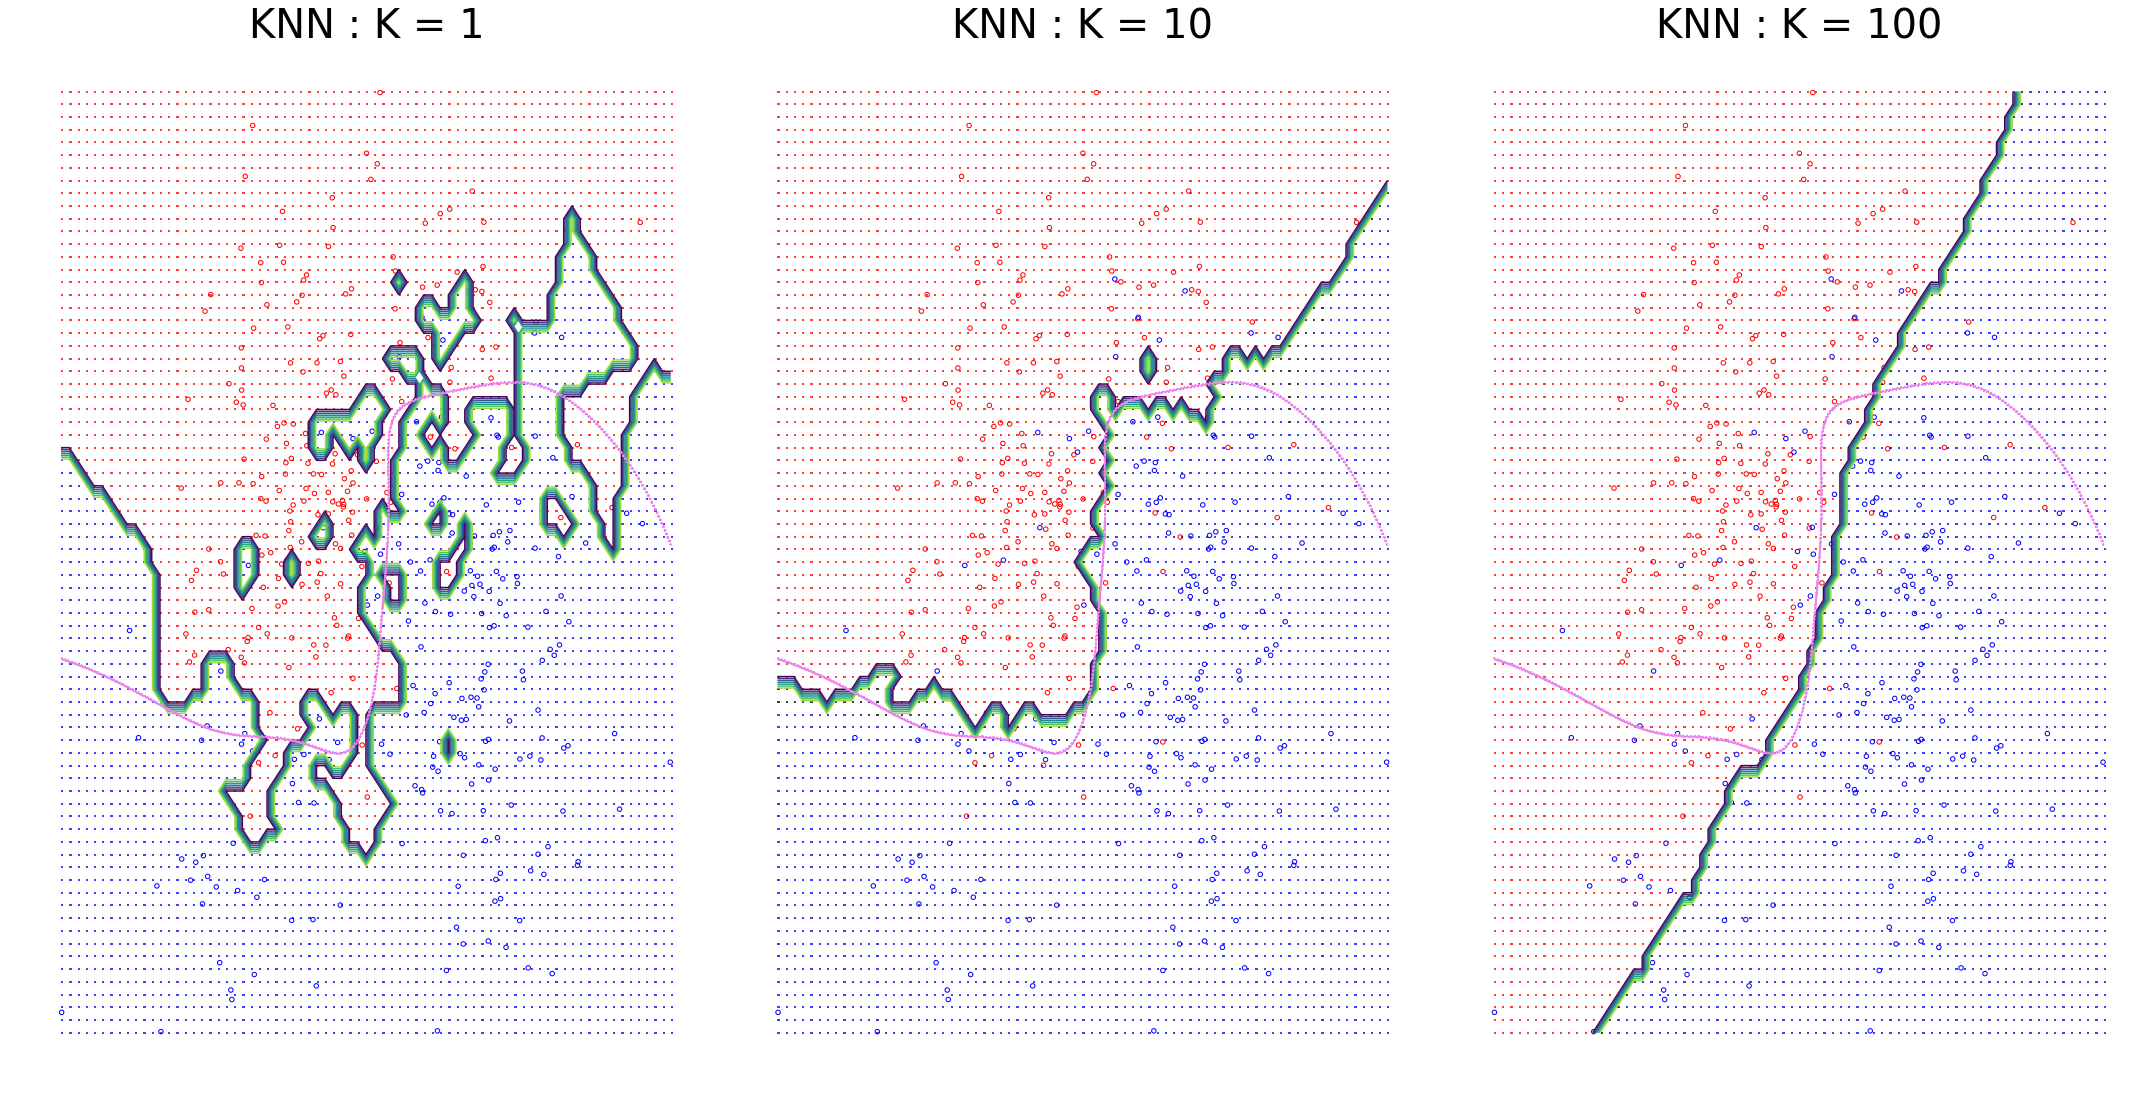

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1 , 3 , figsize = (30, 15))
fig.tight_layout()
sub = 0
for i in [1, 10, 100] : 
    visual(i ,x ,y , sub )
    sub +=1
plt.show()


In [24]:
pred_dict = {}
for i , j in enumerate(choice) :
    pred_dict.update({ i : j})

In [25]:
sample_pred = np.argmin(dist , axis = 0 ) 
pred = pd.DataFrame(sample_pred).replace(pred_dict)
train_acc = np.sum(pred.T.values[0] == np.array(label)) / len(label)

## 예측 방법

* K 개수 만큼 가장 가까운 점을 뽑는다.
* Grid 점 별로 색깔의 확률값으로 나타낸다. 
* 각 점에서의 확률값을 구하고 `0.5`를 기준으로 분류
* 각 점의 index를 dictionary 형태로 만든다.
* 샘플에서 가장 가까운 Index를 구하고 Dictionary를 사용해 Mapping한다.
    * 가장 가까운 점의 클래스가 곧 자신의 클래스 된다라고 생각하고 구현함.
* 만약 뽑힌 점과 샘플의 label 이 같은지 다른지를 판단하고 Error 계산

In [26]:
def knn_acc(dist , k , n) :
    # 기존은 위의 방법, 밑에는 더 빠르게 하기위해 바꾼 방법.
    #arg_min_k = np.argpartition(dist, np.argmin(dist, axis=1))[:, :k]
    arg_min_k = dist.apply(lambda x : np.argpartition(x , k)[ : k], axis=1).values
    change_type = np.where(arg_min_k >= n  ,  1 , 0 )
    prob = np.sum(change_type , axis = 1 ) / k
    choice = np.where(prob > 0.5 , "blue" ,
             np.where(prob < 0.5 , "red", "black"))
    pred_dict = {}
    ## 한 점마다 0.5의 기준으로 색깔이 분류가 된다. 
    ## 이 색깔이 분류가 된 점을 Dictionary 형태로 가져온다.
    for i , j in enumerate(choice) :
        pred_dict.update({ i : j})
    ## 그 다음 샘플에서 가장 거리가 가까운 grid 점을 찾고
    ## 그 점이 가지는 색깔이 곧 예측한 Class라고 할 수 있다고 생각한다.
    sample_pred = np.argmin(dist.values , axis = 0 ) 
    ## 이 부분에서 오래걸리는 것 같다. 
    ## Data Sample에서 한개당 한번씩 훑어서 느린 것 같다.
    pred = pd.DataFrame(sample_pred, columns = ["idx"])["idx"].map(pred_dict)
    train_acc = np.sum(pred.T.values == np.array(label)) / len(label)
    train_error = 1 - train_acc
    return train_error

In [27]:
%%time

step = np.linspace(1, 100 , num= 30).astype(int).tolist()
step = [2] + step
step = list(np.sort(step))
store = []
dist2 = pd.DataFrame(dist)
for i in step :
    store.append(knn_acc(dist2 , i , n = 200))

CPU times: user 1min 7s, sys: 364 ms, total: 1min 8s
Wall time: 1min 9s


In [28]:
n = 2500
mix_1 = mixture_5(mean = mean , cov = cov , p =  p , N= n)
mix_2 = mixture_5(mean = mean , cov = cov , p =  p , N= n)
label = ["red"] * n  + ["blue"]  * n
total  = np.concatenate((mix_1 , mix_2), axis = 0)

grid_n = 100 ## 1000 개 메모리 에러 발생.
x_min, x_max = total[:,0].min() - .01, total[:,0].max() + .01
y_min, y_max = total[:,1].min() - .01, total[:,1].max() + .01
x = np.linspace(x_min , x_max , num = grid_n)
y = np.linspace(y_min, y_max  , num = grid_n)
x, y = np.meshgrid(x , y )

grid_xy = np.concatenate((x[:, : , np.newaxis],
                     y[:, : , np.newaxis]),
                    axis = 2)
reshape_grid = grid_xy.reshape(grid_n*grid_n , 2)
print(total.shape , reshape_grid.shape)
metric = "euclidean"
dist = cdist( reshape_grid, total, metric=metric )

(10000, 2) (10000, 2)


## 매우 느리지만, 개선함.
    * test 샘플이 3000개로 했을 때 거리를 구하다보니 연산량이 많아 시간이 오래 걸림.
    * test 총 9min 35s  -> 2min 28s 개선

In [29]:
%%time

test_store = []
dist2 = pd.DataFrame(dist)
for i in step :
    test_store.append( knn_acc(dist2 , i  , n = n) )

CPU times: user 3min 38s, sys: 20.2 s, total: 3min 58s
Wall time: 4min 3s


## 개선 사항

* 구현 도중 좀 더 빠르게 하기 위해 시도

In [30]:
import time
start_1 = time.time()
k = 4
arg_min_k = np.argpartition(dist, np.argmin(dist, axis=1))[:, :k]
arg_min_k.shape
end_1 = time.time()

start_2 = time.time()
dist_t = pd.DataFrame(dist)
dd = dist_t.apply(lambda x : np.argpartition(x , 4)[:4], axis=1)
end_2 = time.time()

print("전 : {:.2f}초 --> 후 : {:.2f}초 ".format(end_1 - start_1 , end_2 - start_2))

전 : 19.49초 --> 후 : 6.13초 


In [31]:
step = np.linspace(1, 100 , num= 30).astype(int).tolist()
step = [2] + step
step = list(np.sort(step))
step_reverse = list(1 / np.array(step))


trace = go.Scatter(
    x = step_reverse,
    y = store,
    mode = 'lines+markers',
    name ='Training Erros',
)
trace2 = go.Scatter(
    x = step_reverse,
    y = test_store,
    mode = 'lines+markers',
    name ='Test Errors',
)
trace_line = go.Scatter(
    x= step_reverse,
    y= [np.min(test_store)-0.01] * len(step),
    name = "minimum test error" , 
    mode ='lines'
)
data = [trace , trace2 , trace_line]

layout = dict(title = 'K-Nearest Neighbors',
              xaxis = dict(title = '1 / K'),
              yaxis = dict(title = 'Error Rates'),
              width=1000,
              height=700,
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')

/usr/local/lib/python3.5/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



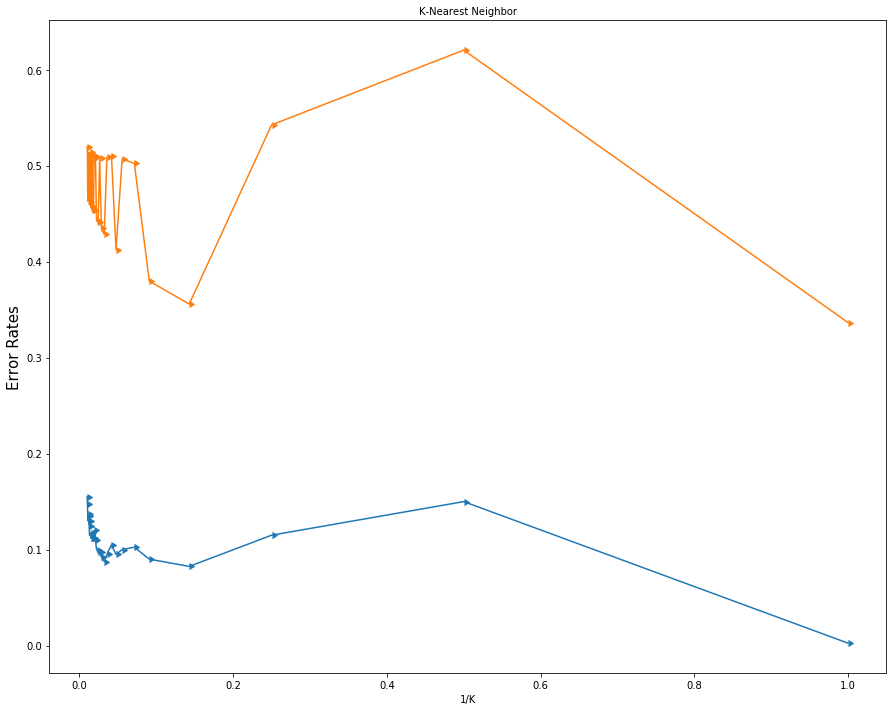

In [32]:
step = np.linspace(1, 100 , num= 30).astype(int).tolist()
step = [2] + step
step = list(np.sort(step))
step_reverse = list(1 / np.array(step))
plt.figure(figsize=(15,12))
plt.plot(step_reverse , store , marker = 9 )
plt.plot(step_reverse , test_store , marker = 9)
plt.title("K-Nearest Neighbor", fontsize = 10)
plt.xlabel("1/K", fontsize = 10)
plt.ylabel("Error Rates", fontsize = 15)
plt.show()

## 참고

[시각화](https://github.com/sitzikbs/gmm_tutorial/blob/master/visualization.py)

[knn 구현 참고](http://dataaspirant.com/2016/12/27/k-nearest-neighbor-algorithm-implementaion-python-scratch/)

[knn 구현 참고 2](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)

[knn 구현 참고 3](https://www.python-course.eu/k_nearest_neighbor_classifier.php)

[r contour 시각화](https://stats.stackexchange.com/questions/21572/how-to-plot-decision-boundary-of-a-k-nearest-neighbor-classifier-from-elements-o)

[knn Decision Boundaries plotly](https://plot.ly/scikit-learn/plot-voting-decision-regions/)

[numpy에서 replace 하는 방법](https://stackoverflow.com/questions/33529593/how-to-use-a-dictionary-to-translate-replace-elements-of-an-array)


[norm = LogNorm을 하니 그럴 듯하게 나온다.](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py)
[matrix가 다를 때 거리재는 방법](https://stackoverflow.com/questions/1871536/minimum-euclidean-distance-between-points-in-two-different-numpy-arrays-not-wit)

[matrix 에서 가장 작은 것이나 큰 것 몇 개 가지고 오는 방법](https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array/27433395)
